In [2]:
import wfdb
from wfdb import processing
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import figure
from scipy.fft import fft, ifft
import math

In [38]:
def load_data(path):
    """Loads database file and returns ECG signal samples and fields list"""
    try:
        signals, fields = wfdb.rdsamp(path)
        ecg = signals[:,0]
        ecg = ecg.flatten()
        ecg = high_pass_filter(ecg, fields["fs"])
        return ecg, fields
    
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None


def estimate_threshold(signal, perc=92):
    return np.percentile(signal, perc)


def high_pass_filter(signal, samp_rate, cutoff_freq=50):
    tau = 1 / (2 * np.pi * cutoff_freq)
    alpha = tau / (tau + 1 / (2 * np.pi * samp_rate))
    y_prev = 0
    x_prev = 0

    filtered_signal = []
    for x in signal:
        y = alpha * (y_prev + x - x_prev)
        filtered_signal.append(y)
        y_prev = y
        x_prev = x

    return np.array(filtered_signal)

def remove_baseline_wander_fft(ekg_data, sampling_rate=4, cutoff_frequency=0.5):
    """Removes the baseline wander for better manipulation with data. Using Fourier Transformation
    to locate lowfrequency components and erasing them."""
    spectrum = fft(ekg_data)
    freq = np.fft.fftfreq(len(ekg_data), 1/sampling_rate)
    spectrum[(freq > -cutoff_frequency) & (freq < cutoff_frequency)] = 0
    ekg_without_baseline = np.real(ifft(spectrum))
    return ekg_without_baseline


def find_Rpeaks(signal):
    """Finds R peaks in ECG signal with dynamically changing window size.
    Returns a list of peaks and corresponding times."""
    threshold = estimate_threshold(signal)
    peaks = []
    is_peak = False
    current_peak_value = -np.inf
    current_peak_index = 0

    for i, value in enumerate(signal):
        if value > threshold:
            if not is_peak or value > current_peak_value:
                current_peak_value = value
                current_peak_index = i
            is_peak = True
        else:
            if is_peak:
                peaks.append(current_peak_index)
                is_peak = False
    return np.array(peaks)
    

def count_rpeaks_in_windows(signal, r_peaks, samp_rate):
    """Counts number of Rpeaks in every 15 seconds"""
    signal_duration = len(signal) / samp_rate  # Doba trvání signálu v sekundách
    window_duration = 15.0  # Délka okna v sekundách
    window_count = int(signal_duration / window_duration)  # Počet oken

    r_peak_counts = [0] * window_count  # Inicializace seznamu počtu R píků v jednotlivých oknech

    for r_peak in r_peaks:
        window_index = int(r_peak / (samp_rate * window_duration))  # Určení indexu okna, do kterého patří R pík
        if 0 <= window_index < window_count:
            r_peak_counts[window_index] += 1  # Zvýšení počtu R píků v příslušném okně

    return r_peak_counts


def plot_bpm_over_time(bpm_values, driver, window_duration=10.0):
    """BPM plot"""
    time_axis = [i * window_duration / 60.0 for i in range(len(bpm_values))]
    
    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, bpm_values, linestyle='-', color='b')
    plt.title('BPM v závislosti na čase pro měření ' + driver)
    plt.xlabel('Čas (minuty)')
    plt.ylabel('BPM')
    plt.grid(True)
    plt.show()

[   20    23    76 ... 78038 78043 78053]


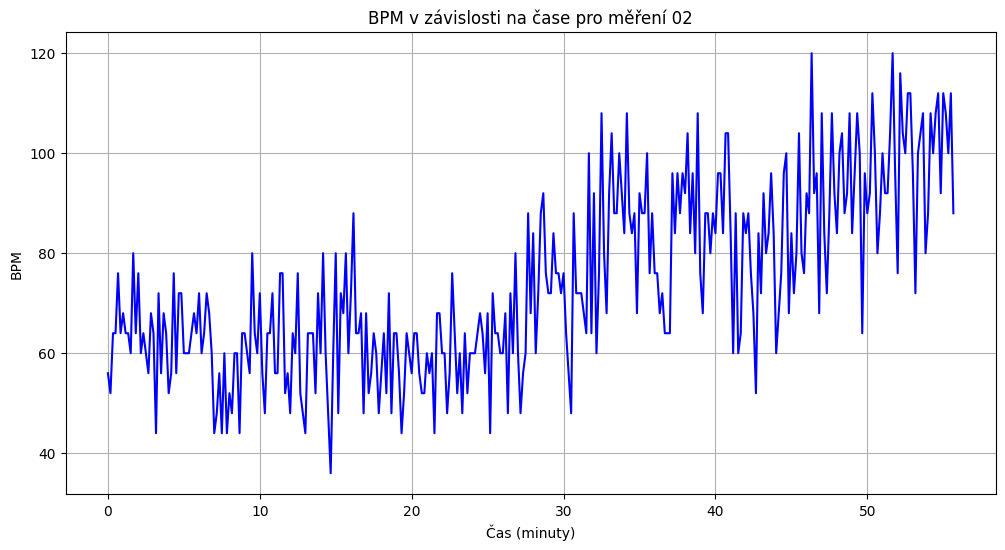

In [21]:
database = 'Database/drive02'
driver = database[-2:]
ECGnative, fields = load_data(database)
samp_rate = fields['fs']

ecg_data = np.array(ECGnative)
cutoff_frequency = 0.5

ecg_edit_fft = remove_baseline_wander_fft(ecg_data, samp_rate, cutoff_frequency=cutoff_frequency)
Rpeaks = find_Rpeaks(ecg_edit_fft)
print(Rpeaks)
r_peak_counts = [count* 4 for count in count_rpeaks_in_windows(ecg_edit_fft, Rpeaks, samp_rate)]

plot_bpm_over_time(r_peak_counts, driver)

In [52]:
def evaluate_detection(true_peaks, detected_peaks, correct_threshold=0.0001):
    correct = 0
    total = len(true_peaks)
    for true_peak in true_peaks:
        detected = False
        for detected_peak in detected_peaks:
            delta = (true_peak+1) / (detected_peak+1)
            deltap = np.abs(1-delta)
            if deltap < correct_threshold:
                detected = True
                break

        if detected:
            correct += 1

    return correct, total - correct, total, len(detected_peaks)

def test_file(file_path, sampfrom=0, nsamp=100000, correct_threshold=0.0001):
    signal, _ = wfdb.rdsamp(file_path, channels=None, sampfrom=sampfrom, sampto=sampfrom+nsamp)
    true_peaks = wfdb.rdann(file_path, extension="atr", sampfrom=sampfrom, sampto=sampfrom+nsamp).sample
    signal = signal[:, 0]
    detected_peaks = find_Rpeaks(signal)
    return evaluate_detection(true_peaks, detected_peaks, correct_threshold)

In [53]:
import os
import pandas as pd

success_count = 0
total_count = 0

data = []

for file in os.listdir("test_data"):
    if file[-3:] != "dat":
        continue
    
    file = file[:-4]
    correct, wrong, total, peaks = test_file("test_data/" + file)
    success_count += correct
    total_count += total

    success_rate = correct / total * 100

    data.append([file, correct, wrong, total, success_rate])

df = pd.DataFrame(data, columns=["File", "Correct", "Wrong", "Total", "Success rate"])
total_success_rate = success_count / total_count * 100

print("Test results:")
print(df)
print(f"Total success rate: {total_success_rate:.2f}%")

Test results:
     File  Correct  Wrong  Total  Success rate
0   16265     1142    175   1317     86.712225
1   16272      804    193    997     80.641926
2   16273     1006    237   1243     80.933226
3   16420      906    248   1154     78.509532
4   16483      930    241   1171     79.419300
5   16539     1030     65   1095     94.063927
6   16773      824    567   1391     59.237958
7   16786      754    210    964     78.215768
8   16795      759    300   1059     71.671388
9   17052      860    258   1118     76.923077
10  17453      930    104   1034     89.941973
11  18177     1231    262   1493     82.451440
12  18184      920    281   1201     76.602831
13  19088     1028    353   1381     74.438812
14  19090     1034    114   1148     90.069686
15  19093      771    190    961     80.228928
16  19140      996    267   1263     78.859857
17  19830     1265    159   1424     88.834270
Total success rate: 80.27%
